In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=1, max_galaxies=1, num_bands=5, num_images=100, brightness = 5000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

In [19]:
images_batch1.shape

torch.Size([10, 5, 31, 31])

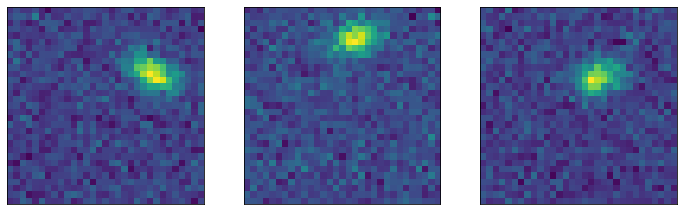

In [18]:
_, axarr = plt.subplots(1, 3, figsize=(12, 12))
for i in range(3): 
    axarr[i].matshow(images_batch1[i, 0, :, :])
    axarr[i].get_xaxis().set_visible(False)
    axarr[i].get_yaxis().set_visible(False)

In [7]:
# The VAE
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

load_warm_start_params = False
if load_warm_start_params: 
    state_dict_attn = torch.load('../galaxy_warm_starts/attn_enc_init.dat', map_location='cpu')
    galaxy_vae.attn_enc.load_state_dict(state_dict_attn, strict=False)

    state_dict_enc = torch.load('../galaxy_warm_starts/galaxy_enc_init.dat', map_location='cpu')
    galaxy_vae.enc.load_state_dict(state_dict_enc, strict=False)

    state_dict_dec = torch.load('../galaxy_warm_starts/galaxy_dec_init.dat', map_location='cpu')
    galaxy_vae.dec.load_state_dict(state_dict_dec, strict=False)

In [8]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [9]:
load_from_results = True
if load_from_results: 
#     state_dict = torch.load('../galaxy_results_final_experiments/reinforce4/galaxy_vae_reinforce4_epoch10.dat', map_location='cpu')
    state_dict = torch.load('../galaxy_results/topk3/galaxy_vae_topk3_epoch10.dat', map_location='cpu')
    galaxy_rnn.load_state_dict(state_dict, strict = True)

FileNotFoundError: [Errno 2] No such file or directory: '../galaxy_results_final_experiments/topk3/galaxy_vae_topk3_epoch10.dat'

In [10]:
galaxy_rnn.eval(); 
galaxy_rnn.one_galaxy_vae.eval(); 

In [11]:
_, loss = galaxy_rnn.get_pm_loss(image = images_batch1, 
                                    image_so_far = backgrounds_batch1, 
                                    var_so_far = backgrounds_batch1, 
                                    alpha = 0.0, 
                                    topk = 0, 
                                    use_baseline = False)

print(loss)

TypeError: sample_conditional_a() takes 4 positional arguments but 5 were given

In [52]:
galaxy_lib.train_epoch(galaxy_rnn, train_loader,
            alpha = 0.0,
            topk = 0,
            use_baseline = False,
            train = False)

tensor(23757.4551)

In [53]:
pixel_probs = galaxy_rnn.get_pixel_probs(resid_image = images_batch1 - backgrounds_batch1, 
                                         var_so_far = backgrounds_batch1)

In [54]:
torch.max(pixel_probs, dim = 1)

(tensor([ 0.0364,  0.1304,  0.0655,  0.2007,  0.0759,  0.0089,  0.0130,
          0.1370,  0.0618,  0.2163]),
 tensor([ 346,   45,  501,   18,   88,    2,  121,   39,  109,   17]))

(array([515.,   5.,   2.,   1.,   4.,   1.,   0.,   0.,   0.,   2.]),
 array([4.56967426e-17, 7.58673623e-03, 1.51734725e-02, 2.27602087e-02,
        3.03469449e-02, 3.79336812e-02, 4.55204174e-02, 5.31071536e-02,
        6.06938899e-02, 6.82806261e-02, 7.58673623e-02]),
 <a list of 10 Patch objects>)

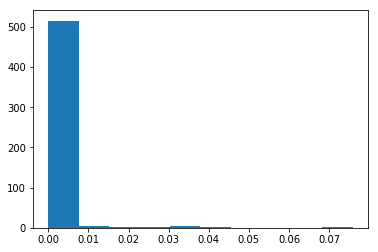

In [55]:
plt.hist(pixel_probs[4, :].detach())

In [56]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [57]:
cond_loss, recon_mean, recon_var = galaxy_rnn.get_loss_conditional_a(images_batch1 - backgrounds_batch1,
                                                                     backgrounds_batch1, 
                                                                     backgrounds_batch1, 
                                                                     map_pixel_loc)

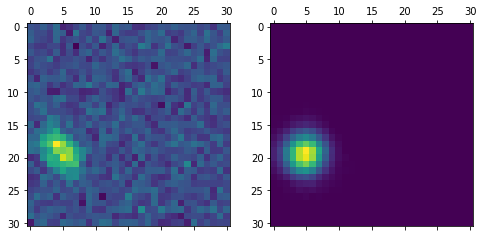

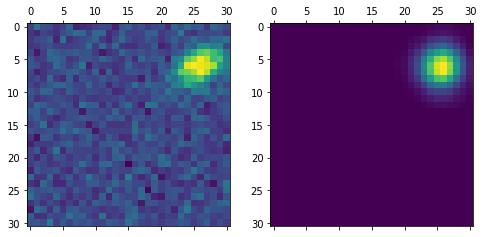

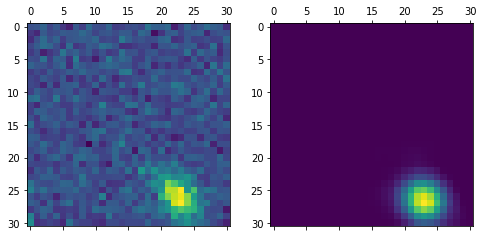

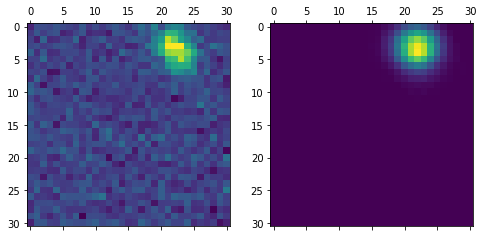

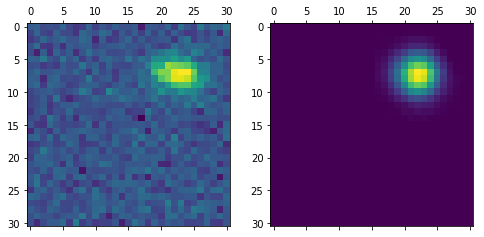

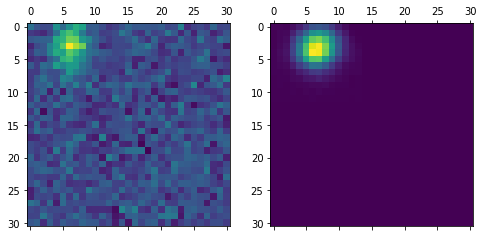

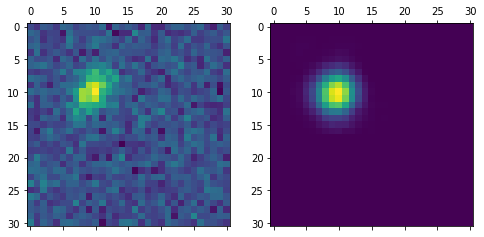

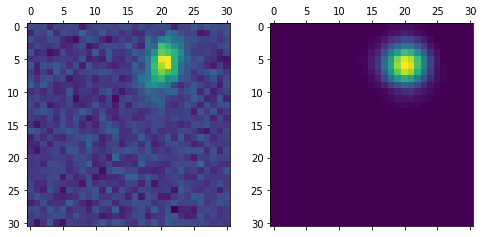

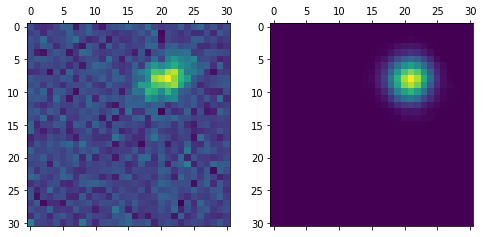

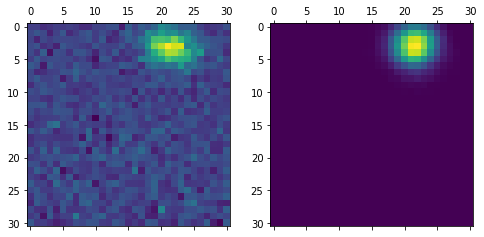

In [58]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())
